# Segmentation of blood vessels in retinal images

In this notebook we are going to segment blood vessels in retina images. The retina image dataset consist of 20 2D images in TIFF format. 
For this task we are going to use the MIScnn framework for medical image segmentation. 

**Install MIScnn framework**

At first we need to install the MIScnn framework

In [ ]:
!pip install miscnn

     |████████████████████████████████| 141 kB 9.4 MB/s 
     |████████████████████████████████| 70 kB 7.8 MB/s 
     |████████████████████████████████| 679 kB 49.9 MB/s 
     |████████████████████████████████| 3.0 MB 36.2 MB/s 
     |████████████████████████████████| 26.3 MB 16 kB/s 
     |████████████████████████████████| 35.4 MB 40 kB/s 
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 3.3 MB 58.6 MB/s 
     |████████████████████████████████| 11.6 MB 27.7 MB/s 
     |████████████████████████████████| 47.4 MB 35 kB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: scikit-image
    Found exis

To plot the results later we need the latest version of matplotlib so we install it here

In [ ]:
!pip install matplotlib==3.4.2

     |████████████████████████████████| 10.3 MB 7.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.1
    Uninstalling matplotlib-3.3.1:
      Successfully uninstalled matplotlib-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
miscnn 1.1.11 requires matplotlib==3.3.1, but you have matplotlib 3.4.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Import libraries

Before we can start building our pipeline we need to import the MIScnn framework. To make the code more clear we have added all imports of the libraries here.

In [ ]:
import miscnn
import numpy as np
import sklearn.model_selection
from google.colab import drive
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import display
from miscnn import Data_IO, Preprocessor, Neural_Network
from miscnn.data_loading.interfaces.image_io import Image_interface
from miscnn.processing.data_augmentation import Data_Augmentation
from miscnn.processing.subfunctions import  Normalization, Resize
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.metrics import dice_soft, dice_crossentropy, tversky_loss, tversky_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from miscnn.evaluation import split_validation, cross_validation
from miscnn.processing.subfunctions.abstract_subfunction import Abstract_Subfunction

## Load the dataset

To be able to load the dataset we first need to connect with Google Drive because we have uploaded the dataset to Google Drive before.

**Connect with Google Drive account**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Create Data IO interface and instance**

Now we can start building our segmentation pipeline. The first step is to establish the Data I/O class. The Data I/O handles the complete data loading of medical images and its segmentation. Because there are different implemented data formats and structures we need to use the right interface for our image type. The images of our dataset have TIFF format and are coloured so we are using the Image IO Interface with 3 channels (rgb).

In [ ]:
# Create Image IO Interface and initialize it
interface = Image_interface(img_type= 'rgb', img_format='tif' )

In [ ]:
# Initialize data path
data_path = '/content/drive/MyDrive/Uni/klinisches Anwendungsprojekt/DRIVE.Retinal_Images.Vessel_Extraction/data'

# Create Data IO instance and pass interface and data path to it
data_io = miscnn.Data_IO(interface, data_path)

## Data exploration

In this step, we will examine our data. When analyzing images, it is always good to know your data set. So we will take a closer look at the number of images, the class distribution and an image and its segmentation.

### Show sample list 

First we get a list of all the samples and print it so we can see how many images our dataset contains.

In [ ]:
# Get a list of indices for all images
sample_list = data_io.get_indiceslist()

# Print sorted list
sample_list.sort()
print(sample_list)

['img01', 'img02', 'img03', 'img04', 'img05', 'img06', 'img07', 'img08', 'img09', 'img10', 'img11', 'img12', 'img13', 'img14', 'img15', 'img16', 'img17', 'img18', 'img19', 'img20']


### Show image and its segmentation

Now we know how many images there are, but not what they look like. So we load an image and its segmentation using the sample_loader method of the data_io class and visualize them via Pillow. We also print the shape of the two images.

Shape of image:  (584, 565, 3)


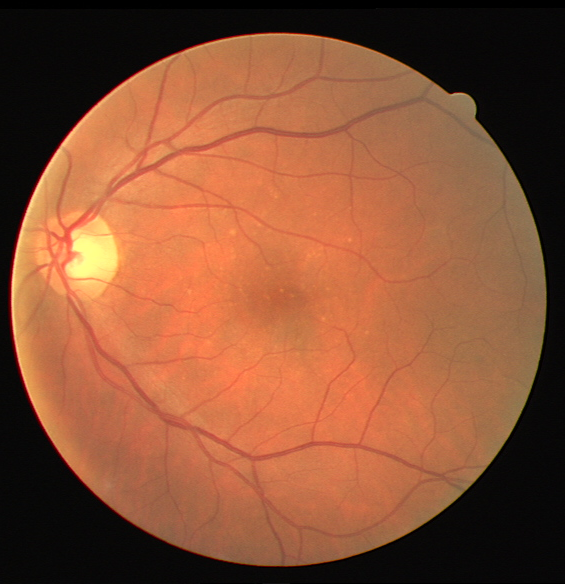

Shape of segmentation:  (584, 565, 1)


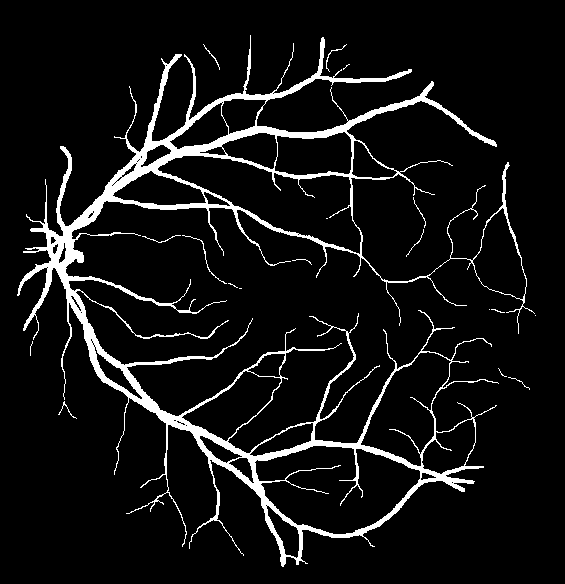

In [ ]:
# Load first sample with sample_loader function from miscnn.data_loading
sample = data_io.sample_loader(sample_list[0], load_seg=True)

# Visualize image
img_data = sample.img_data
print("Shape of image: ", img_data.shape)
img = Image.fromarray(img_data)
display(img)

# Visualize segmentation
seg_data = sample.seg_data
print("Shape of segmentation: ", seg_data.shape)
seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
display(seg)


### Show class balance for each image

In image segmentation, we often have to deal with data imbalance because there are much more background pixels than pixels of the object to be segmented. In our case, blood vessels of the retina. Therefore, we have a look at the class distribution for each image.


In [ ]:
# Create some lists
back_list = []        # List for the number of background pixels of each image
vessel_list = []      # List for the number of vessel pixels of each image
name_list = []        # List for the name of each image
rel_list = []

print("Class distribution of each image \n")
print("image: background : vessel (total pixels) = x times more background than vessel pixels (rounded)")

# Iterate over each sample of the sample list
for img in sample_list:
  # Load the sample and its segmentation
  sample = data_io.sample_loader(img, load_seg=True)
  seg = sample.seg_data
  # Set the counters for the background and vessel pixels to zero
  back = 0
  vessels = 0
  # Iterate over each pixel of the segmentation
  for i in range(seg.shape[0]):
    for j in range(seg.shape[1]):
      # If the pixel has the value zero (black) set the counter for the background one value upwards
      if(seg[i,j] == 0):
        back += 1
      # If the pixel has the value 255 (white) set the counter for the vessels one value upwards
      elif(seg[i,j] == 255):
        vessels += 1
  # Add the counters to their list
  back_list += [back]
  vessel_list += [vessels]
  name_list += [str(img)]
  rel_list += [round(back/vessels)]

  # Print the results
  print(str(img) + ": " + str(back) + ": " + str(vessels) + " = " + str(round(back/vessels)))

Class distribution of each image 

image: background : vessel (total pixels) = x times more background than vessel pixels (rounded)
img01: 305302: 24658 = 12
img02: 300151: 29809 = 10
img03: 308237: 21723 = 14
img04: 291731: 38229 = 8
img05: 298291: 31669 = 9
img06: 302387: 27573 = 11
img07: 300887: 29073 = 10
img08: 297732: 32228 = 9
img09: 302209: 27751 = 11
img10: 304076: 25884 = 12
img11: 310062: 19898 = 16
img12: 302976: 26984 = 11
img13: 303274: 26686 = 11
img14: 297673: 32287 = 9
img15: 301348: 28612 = 11
img16: 294076: 35884 = 8
img17: 301119: 28841 = 10
img18: 301483: 28477 = 11
img19: 301612: 28348 = 11
img20: 304959: 25001 = 12


As we can see now, there are eight to fourteen times more background than vessel pixels. To display the calculated values more clearly, we will visualize the class distribution in different plots with matplotlib. 

**Display scatter plot**

<function matplotlib.pyplot.show>

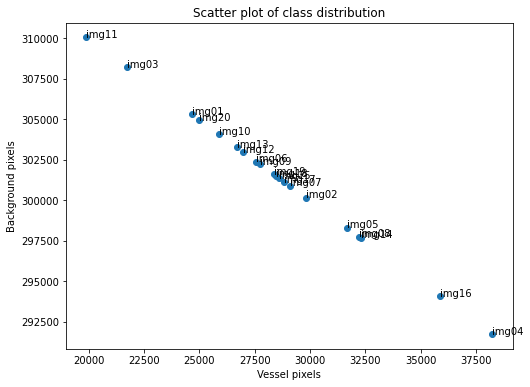

In [ ]:
# Create scatter plot
plt.scatter(vessel_list, back_list)

# Annotate the points with the name of the image
for i, txt in enumerate(name_list):
  plt.annotate(txt, (vessel_list[i], back_list[i]))

# Set title, labels and figure size
plt.title("Scatter plot of class distribution")
plt.xlabel("Vessel pixels")
plt.ylabel("Background pixels")
plt.rcParams["figure.figsize"]= (8, 6)

# Show scatter plot
plt.show

This is a scatter plot of the class distribution, showing the number of background pixels and the number of vessel pixels for each image.  We can see approximately which pixel values are frequently occurring, but there are better representations for this, such as the histogram which we will plot next.

**Display histogram**

To be able to show how often which class distribution occurs in our data set, we will create three histograms. One in which we show the frequency of the background pixel. One in which we plot the frequency of the vessel pixels. And one in which we plot the frequency of the class distribution, i.e. the ratio of background pixel to vessel pixel.

<function matplotlib.pyplot.show>

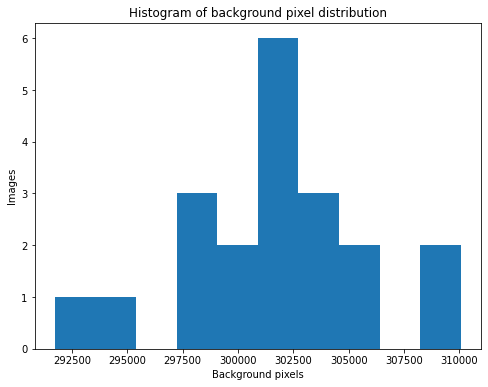

In [ ]:
# Create histogram of background pixel distribution
plt.hist(back_list)

# Set title and labels
plt.title("Histogram of background pixel distribution")
plt.xlabel("Background pixels")
plt.ylabel("Images")

# Show histogram
plt.show

<function matplotlib.pyplot.show>

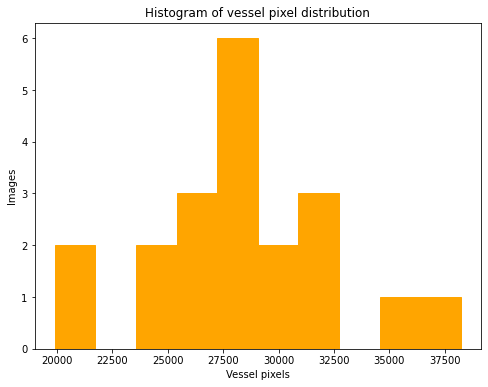

In [ ]:
# Create histogram of vessel pixel distribution
plt.hist(vessel_list, color= "orange", ec="orange")

# Set title and labels
plt.title("Histogram of vessel pixel distribution")
plt.xlabel("Vessel pixels")
plt.ylabel("Images")

# Show histogram
plt.show

<function matplotlib.pyplot.show>

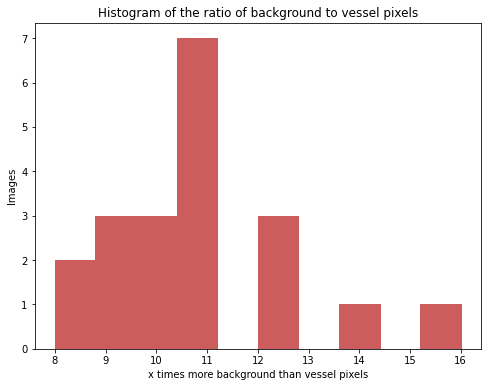

In [ ]:
# Create histogram of the ratio of background to vessel pixels
plt.hist(rel_list, color= "indianred", ec="indianred")

# Set title and labels
plt.title("Histogram of the ratio of background to vessel pixels")
plt.xlabel("x times more background than vessel pixels")
plt.ylabel("Images")

# Show histogram
plt.show

Text(0.5, 1.0, 'Background/vessel ratio')

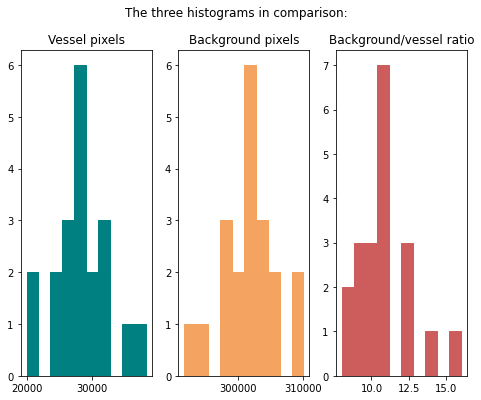

In [ ]:
# Create horizontally stacked subplots
fig, axs = plt.subplots(1, 3)

# Create the previous three histograms 
axs[0].hist(vessel_list, color="teal", ec="teal")
axs[1].hist(back_list, color="sandybrown", ec="sandybrown")
axs[2].hist(rel_list, color= "indianred", ec="indianred")

# Set titles 
plt.suptitle("The three histograms in comparison:")
axs[0].set_title("Vessel pixels")
axs[1].set_title("Background pixels")
axs[2].set_title("Background/vessel ratio")

## Preprocessing of the data

### Create the data augmentation class

Since our dataset consists of only 20 images and is therefore very small, it is important to work with data augmentation. To generate as much additional training data as possible, we will use all available data augmentation techniques. This way we can achieve better results and avoid overfitting.

In [ ]:
# Create data augmentation class
data_augmentation = Data_Augmentation(cycles=2, scaling=True, rotations=True,
                                      elastic_deform=True, mirror=True, 
                                      brightness=True, contrast=True, gamma=True, 
                                      gaussian_noise=True)

### Create a preprocessing Subfunction 

As we have already seen in the Data Exploration step, the segmentation of an image consists only of the two values black and white. Each background pixel is black and each vessel pixel is white. 
So the segmentation model should decide for each pixel whether it is background or vessel. However, the model can only work with consecutive values as classes, so we have to change each 255 value to 1 for training and back again after training. To do this we create our own preprocessing subfunction, for this MIScnn provides an abstract subfunction class where we will define our required functions. 

In [ ]:
class ChangeValues(Abstract_Subfunction):
   #---------------------------------------------#
   #                Initialization               #
   #---------------------------------------------#
  def __init__(self, val_to_change, change_in):
    self.val_to_change = val_to_change
    self.change_in = change_in
    #---------------------------------------------#
    #                Preprocessing                #
    #---------------------------------------------#
  def preprocessing(self, sample, training=True):
    seg_temp = sample.seg_data
    if(sample.seg_data is not None):
      sample.seg_data = np.where(seg_temp == self.val_to_change, self.change_in, seg_temp)
    #---------------------------------------------#
    #               Postprocessing                #
    #---------------------------------------------#
  def postprocessing(self, sample, prediction):
    pred = prediction
    if prediction is not None:
      prediction = np.where(pred == self.change_in, self.val_to_change, pred)
    return prediction

### Select subfunctions for the preprocessing

Here we select subfunctions for the pre- and postprocessing to pass to the preprocessor class. We will use the subfunction we already defined and two other subfunctions that MIScnn provides. One is the normalization of the pixel values and one is the resizing of the images.

In [ ]:
# Create a pixel value normalization subfunction through Z-Score
sf_normalization = Normalization(mode="z-score")
# Create our pixel value changing subfunction
sf_change = ChangeValues(val_to_change=255, change_in=1)
# Create a resizing subfunction to shape 592x592
sf_resize = Resize((592, 592))

# Add subfunctions to a list to pass it to the preprocessor class
subfunc = [sf_resize, sf_change, sf_normalization]

### Create the preprocessor class

Now we create the Preprocessor and pass our created subfunctions and data augmentation to it. We also set the analysis type to full image. 

In [ ]:
# Create and initialize preprocessor
preprocessor = Preprocessor(data_io=data_io, data_aug=data_augmentation, 
                            batch_size=2, subfunctions=subfunc, 
                            prepare_subfunctions=True, prepare_batches=False, 
                            analysis="fullimage")

## Creation and training of the model

### Create the model

In this step we can finally create our model. We will use a model with default values, but with different metrics and a different loss function. 
For loss function we will use the tversky_loss function. 
The metrics we want to check are dice_soft and dice_crossentropy.

In [ ]:
# Create the neural network model
model = Neural_Network(preprocessor=preprocessor, loss=tversky_loss,
                       metrics=[dice_soft, dice_crossentropy])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Create callbacks

Before we train our model, let's create some callbacks to optimize the training.
The callbacks monitor a certain metric and if no improvement occurs for a number of epochs, they do something. We use the ReduceLROnPlateau and the EarlyStopping callback. We have both callbacks monitor for validation loss with a patience of five epochs, also we set the mode to min. So the 

* ReduceLROnPlateau callback reduces the learning rate if the validation loss has not decreased for five epochs, and the

* EarlyStopping callback stops the training if the validation loss has not decreased for five epochs.

In [ ]:
# Define callback reduce learning rate on plateau
cb_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                          mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)
# Define callback early stopping
cb_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, 
                      mode='min')

### Split dataset in a test, train and validation set

To evaluate our model after training, we need a test set that is not available to the model during training. So we split our data set random into two sets. 15% for the test set (3 images) and 85% for the training set (17 images). To see which images are in which set, we will print both sets. 
To see how well our model performs in training, we need another set, the validation set. The model makes a prediction for the validation set after each epoch during training to check how good the network already is. Based on the validation loss, we then also adjust the learning rate or stop the training if no improvement has occurred for too long (callbacks). 
But here we don't need to split the training set into a training and validation set, because we do that automatically in the next step, the training. So in this step we create a test and a training/validation set.

In [ ]:
# Split dataset into train_val and test set
train_val, test = sklearn.model_selection.train_test_split(sample_list, train_size=17, test_size=3)

# Sort both sets and print them
train_val.sort()
test.sort()
print(test)
print(train_val)

['img02', 'img04', 'img05']
['img01', 'img03', 'img06', 'img07', 'img08', 'img09', 'img10', 'img11', 'img12', 'img13', 'img14', 'img15', 'img16', 'img17', 'img18', 'img19', 'img20']


If we want to load the last trained model to continue working with it, we create the test and train/validation set with the same images that were used in training and do not use random splitting. In this case we will remove the # and run the cell, otherwise we will just skip it.

In [ ]:
# Create test and train/ validation set 
#test = ['img02', 'img04', 'img05']
#train_val = ['img01', 'img03', 'img06', 'img07', 'img08', 'img09', 'img10', 'img11', 'img12', 'img13', 'img14', 'img15', 'img16', 'img17', 'img18', 'img19', 'img20']

### Train the model

With the split validation method we finally train our model. Split validation automatically splits the train_val set into a training and a validation set and starts the training. We use the default value of 20% for the validation set. We also set epochs to 50, iterations to 20, and pass our created callbacks. 

In [ ]:
split_validation(train_val, model, epochs=50, iterations=20, callbacks=[cb_lr, cb_es], draw_figures=True)

Epoch 1/50
20/20 [==============================] - 444s 22s/step - loss: 1.1086 - dice_soft: 0.4457 - dice_crossentropy: 1.3780 - val_loss: 1.1846 - val_dice_soft: 0.4077 - val_dice_crossentropy: 1.2427
Epoch 2/50
20/20 [==============================] - 442s 22s/step - loss: 0.9718 - dice_soft: 0.5141 - dice_crossentropy: 1.2990 - val_loss: 1.1412 - val_dice_soft: 0.4293 - val_dice_crossentropy: 1.1303
Epoch 3/50
20/20 [==============================] - 440s 22s/step - loss: 0.8768 - dice_soft: 0.5616 - dice_crossentropy: 1.3290 - val_loss: 1.0883 - val_dice_soft: 0.4558 - val_dice_crossentropy: 1.0010
Epoch 4/50
20/20 [==============================] - 450s 23s/step - loss: 0.7903 - dice_soft: 0.6048 - dice_crossentropy: 1.3339 - val_loss: 1.0511 - val_dice_soft: 0.4744 - val_dice_crossentropy: 0.9123
Epoch 5/50
20/20 [==============================] - 451s 23s/step - loss: 0.7487 - dice_soft: 0.6256 - dice_crossentropy: 1.2981 - val_loss: 1.0316 - val_dice_soft: 0.4841 - val_dice_c

After our model is trained, we want to save the model for later access. 

In [ ]:
# Save the model
model.dump("/content/drive/MyDrive/Uni/klinisches Anwendungsprojekt/model_split_50.hdf5")

## Results of the train/validation set

We should take a look at the different metrics to see how the training went. For each metric (dice soft, dice crossentropy, loss) we will show the automatically generated plots.

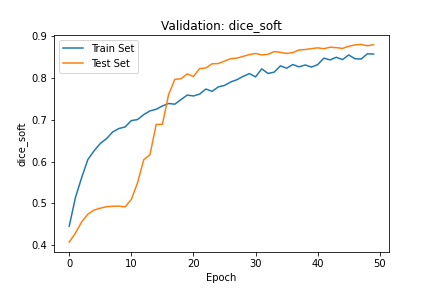

In [ ]:
from IPython.display import Image
Image(filename = "evaluation/validation.dice_soft.png")

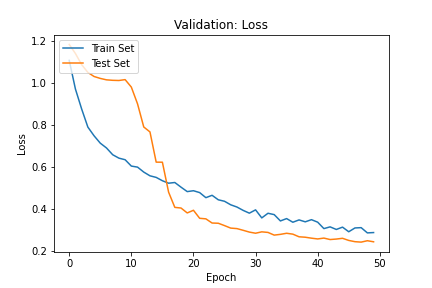

In [ ]:
Image(filename = "evaluation/validation.loss.png")

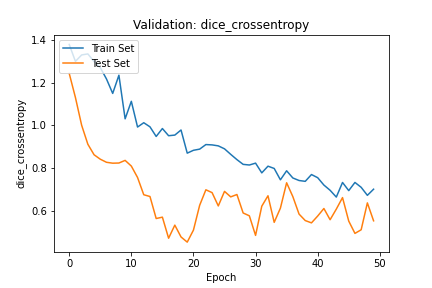

In [ ]:
Image(filename = "evaluation/validation.dice_crossentropy.png")

The plots show the values of the particular metric over the period of the training (epochs) for the training and validation set. The validation set is called test set here, because it is the test set of the training and the actual test set is unknown to the model so far.

## Results of the test dataset

Now we want to see how well the model copes with unknown data, the test set. Therefore, we will load the trained model and let it make a prediction for the test set. Then we will visualize the prediction and compute the dice similarity coefficient.

In [ ]:
# Load the model
model.load("/content/drive/MyDrive/Uni/klinisches Anwendungsprojekt/model_split_50.hdf5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Make prediction for test set
model.predict(test)

**Show prediction and segmetation of the first (test) image**

To find out how good the prediction is, we visualize the ground truth segmentation and the segmentation created by the model. 

Shape of segmentation: (584, 565, 1)


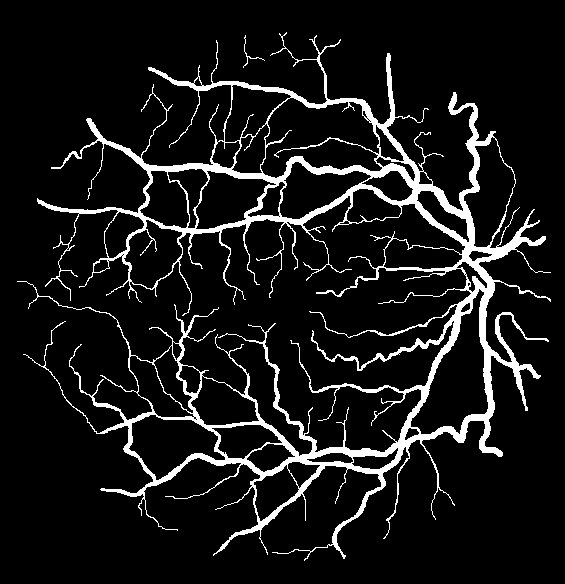

Shape of prediction: (584, 565, 1)


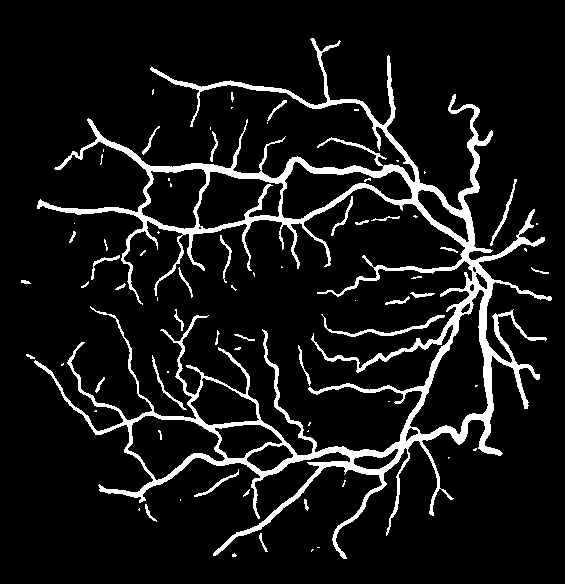

In [ ]:
from PIL import Image
# Load the first sample
sample_test = data_io.sample_loader(test[0], load_seg=True, load_pred=True)

# Visualize the ground truth segmetation
seg_data = sample_test.seg_data 
print("Shape of segmentation:", seg_data.shape)
seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
display(seg)

# Visualize the predicted segmentation
pred_data = sample_test.pred_data
print("Shape of prediction:", pred_data.shape)
pred = Image.fromarray(np.reshape(pred_data, pred_data.shape[:-1]))
display(pred)

As we can see, the model segments the large and small blood vessels very well.  Only for the smallest ones the model has difficulties. But since we trained with a very small dataset, the result is very good.

### Compute dice similarity coefficient

In image segmentation, the dice similarity coefficient is often used to estimate the quality of a model. The dice similarity coefficient is a value between 0 and 1 that indicates how similar the ground truth segmentation and the predicted segmentation are. Here, 1 means the greatest similarity between prediction and ground truth.
So in the following we will define a function for calculating the score, compute it for all images of the test set and then plot the results.

In [ ]:
# Define Calculation of dice similarity coefficient
def calc_DSC(truth, prediction, classes):
    dice_scores = []
    # Iterate over each class
    for i in range(classes):
      if i == 0:
        j = 0
      elif i == 1:
        j = 255
      try:
          gt = np.equal(truth, j)
          pd = np.equal(prediction, j)
          # Calculate Dice
          dice = 2*np.logical_and(pd, gt).sum() / (pd.sum() + gt.sum())
          dice_scores.append(dice)
      except ZeroDivisionError:
          dice_scores.append(0.0)
    # Return computed dice similarity coefficients
    sum = 0
    for i in range(classes):
      sum += dice_scores[i]
    dice = sum / classes
    return dice, dice_scores[1], dice_scores[0]

In [ ]:
# Create lists for the different scores
dices_vessel = []
dices_background = []
dices_both = []
imgs = []

# Compute dice similarity coefficient for all test images
for i in range(len(test)):
  sample = data_io.sample_loader(test[i], load_seg=True, load_pred=True)
  dice, dsc_vessel, dsc_back = calc_DSC(sample.seg_data, sample.pred_data, classes=2)
  dices_vessel.append(dsc_vessel)
  dices_background.append(dsc_back)
  dices_both.append(dice)
  imgs.append(test[i])

# Print dice scores for first test image
print("Dice similarity coefficients for test picture " + imgs[0] + ": ")
print("Segmented vessels:", dices_vessel[0])
print("Segmented background:", dices_background[0])
print("Whole segmentation", dices_both[0])

Dice similarity coefficients for test picture img02: 
Segmented vessels: 0.7856387532101314
Segmented background: 0.9787271609729771
Whole segmentation 0.8821829570915543


### Box plot dice similarity coeffcient

To show the dice similarity coefficient for the test images more clearly, we will create a boxplot and a bar chart. In both we will plot the score respectively for the blood vessels, the background and both together, i.e. the whole segmentation.

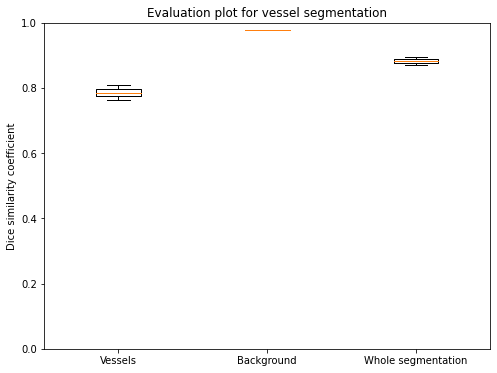

In [ ]:
# Create subplot
fig, ax = plt.subplots()
ax.boxplot([dices_vessel, dices_background, dices_both])

# Set title and labels
ax.set_title('Evaluation plot for vessel segmentation')
ax.set_ylabel('Dice similarity coefficient')
ax.set_xticklabels(["Vessels", "Background", "Whole segmentation"])

# Set range of y axis from 0 to 1
plt.ylim(0, 1)

# Show Box plot
plt.show()

### Bar chart of dice similarity coefficient

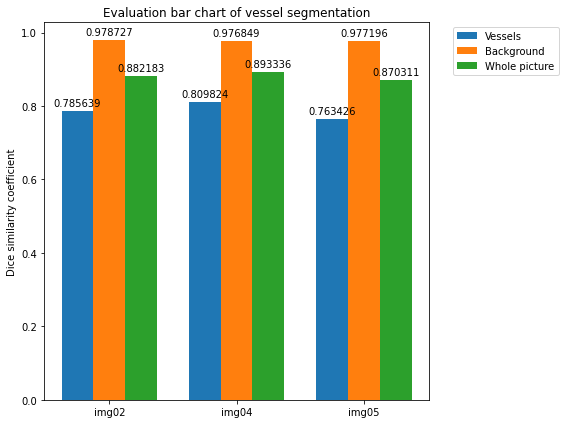

In [ ]:
# Create subplot
fig, ax = plt.subplots()

# Set label location and width of the bars
x = np.arange(len(imgs)) 
width = 0.25  

# Create bars
rects1 = ax.bar(x - width, dices_vessel, width, label='Vessels')
rects2 = ax.bar(x, dices_background, width, label='Background')
rects3 = ax.bar(x + width, dices_both, width, label='Whole picture')

# Set labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dice similarity coefficient')
ax.set_title('Evaluation bar chart of vessel segmentation')
ax.set_xticks(x)
ax.set_xticklabels(imgs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add bar labels
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

# Set layout
fig.tight_layout()

# Show bar chart
plt.show()

As we have now seen, the results for the background are much better than for the blood vessels. This was of course to be expected, since we have a large data imbalance. As we have seen from the Dice Similarity Coefficient of the blood vessels and also from the visualization of the predicted segmentation, the model is not perfect.  However, it is still very good, especially for the small amount of data. 

## Final words

Here I presented the workflow of using MIScnn for medical image segmentation on retinal images. I created this notebook for the clinical application project I did at the Chair of IT Infrastructures for Translational Medical Research. I did the clinical application project as part of my medical informatics studies at the University of Augsburg.

Thanks for reading,<br>
Leonie Burgmann